In [1]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import importlib
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [3]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
                #print('\n',annotation_lines[i],input_shape)                
            image, box = get_random_data(annotation_lines[i], input_shape, random=False,max_boxes=4)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [4]:
def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [5]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [6]:
ss=800
annotation_path = 'train1.txt'
log_dir = 'logs/003/'
classes_path='player_classes.txt'
class_names = get_classes(classes_path)
print(class_names)
num_classes = 1
YOLO_ANCHORS = np.array(
    ((0.7389  , 0.2602), (0.3653, 0.2258), (0.1903  , 0.1437),
     (0.1903 , 0.1352), (0.2278, 0.1078),(0.3097   ,0.0750),
    (0.1514 , 0.1383),(0.1546 ,  0.0836),(0.1083, 0.0766)))
anchors = YOLO_ANCHORS*ss
anchors_number = YOLO_ANCHORS.shape[0]
anchors=anchors[[8,7,6,5,4,3,2,1,0],:]
#print(anchors)

['o']


In [7]:
input_shape = (ss,ss)
model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/yolo_weights.h5')

Create YOLOv3 model with 9 anchors and 1 classes.


c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 18) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 18) vs (255, 512, 1, 1)).
  weight_values[i].shape))
c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
c:\users\popey

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


In [8]:
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [9]:
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(42)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

In [10]:
model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

In [ ]:
batch_size = 4
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=50,
        initial_epoch=0,
        callbacks=[logging, checkpoint])
model.save_weights(log_dir + 'trained_weights_stage_1.h5')

In [33]:
import yolo3.yolo3
importlib.reload(yolo3.yolo3)
from yolo3.yolo3 import YOLO

In [34]:
yolo_class=YOLO(log_dir,'', ss)

logs/003/trained_weights_final.h5
Exception... logs/003/trained_weights_final.h5 False 1 9
logs/003/trained_weights_final.h5 model, anchors, and classes loaded.


In [66]:
import pydicom
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
from os import path

In [16]:
input_shape = (ss,ss)

In [17]:
res=[]
for i in range(100):
    l1 = lines[i]
    l2 = l1.split()
    d = pydicom.read_file(l2[0])
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8'))   
    res.append(r_image)

Found 2 boxes for img
Time:  2.2939512468346335
Found 0 boxes for img
Time:  0.1622008969211337
Found 0 boxes for img
Time:  0.1604951074206502
Found 2 boxes for img
Time:  0.16291717947985562
Found 0 boxes for img
Time:  0.17758808692012762
Found 2 boxes for img
Time:  0.15912960646995344
Found 0 boxes for img
Time:  0.1611229025371368
Found 1 boxes for img
Time:  0.15883371688241033
Found 1 boxes for img
Time:  0.15876478982214337
Found 0 boxes for img
Time:  0.16013277463086784
Found 2 boxes for img
Time:  0.16179944336741592
Found 0 boxes for img
Time:  0.15963817640111344
Found 2 boxes for img
Time:  0.16322486739302988
Found 1 boxes for img
Time:  0.1607894445969258
Found 1 boxes for img
Time:  0.1624210288388337
Found 1 boxes for img
Time:  0.16185688258430453
Found 1 boxes for img
Time:  0.1609642461056211
Found 1 boxes for img
Time:  0.1651585508675497
Found 2 boxes for img
Time:  0.16455373143781848
Found 2 boxes for img
Time:  0.1637672798898162
Found 2 boxes for img
Time:  

KeyboardInterrupt: 

Found 0 boxes for img
Time:  0.1981628144098977
[[556 474 701 655   0]]
556 474 701 655
Found 2 boxes for img
Time:  0.17098537131778357
[[547 281 802 765   0]
 [218 281 429 734   0]]
547 281 802 765
218 281 429 734
Found 0 boxes for img
Time:  0.1602600723545038
[[173 238 381 422   0]
 [234 489 361 770   0]]
173 238 381 422
234 489 361 770
Found 0 boxes for img
Time:  0.15834781215562543
[[198 464 400 745   0]]
198 464 400 745
Found 2 boxes for img
Time:  0.16200094634996276
[[491  80 839 583   0]
 [103  55 379 512   0]]
491 80 839 583
103 55 379 512
Found 2 boxes for img
Time:  0.16526007856464275
[[577 120 831 816   0]
 [122 125 424 779   0]]
577 120 831 816
122 125 424 779
Found 2 boxes for img
Time:  0.1621310384143726
[[572 251 818 602   0]
 [289 223 463 574   0]]
572 251 818 602
289 223 463 574
Found 0 boxes for img
Time:  0.15988190497000687
[[162  88 421 593   0]
 [530 373 820 540   0]]
162 88 421 593
530 373 820 540
Found 2 boxes for img
Time:  0.1629749291787448
[[281 515 44

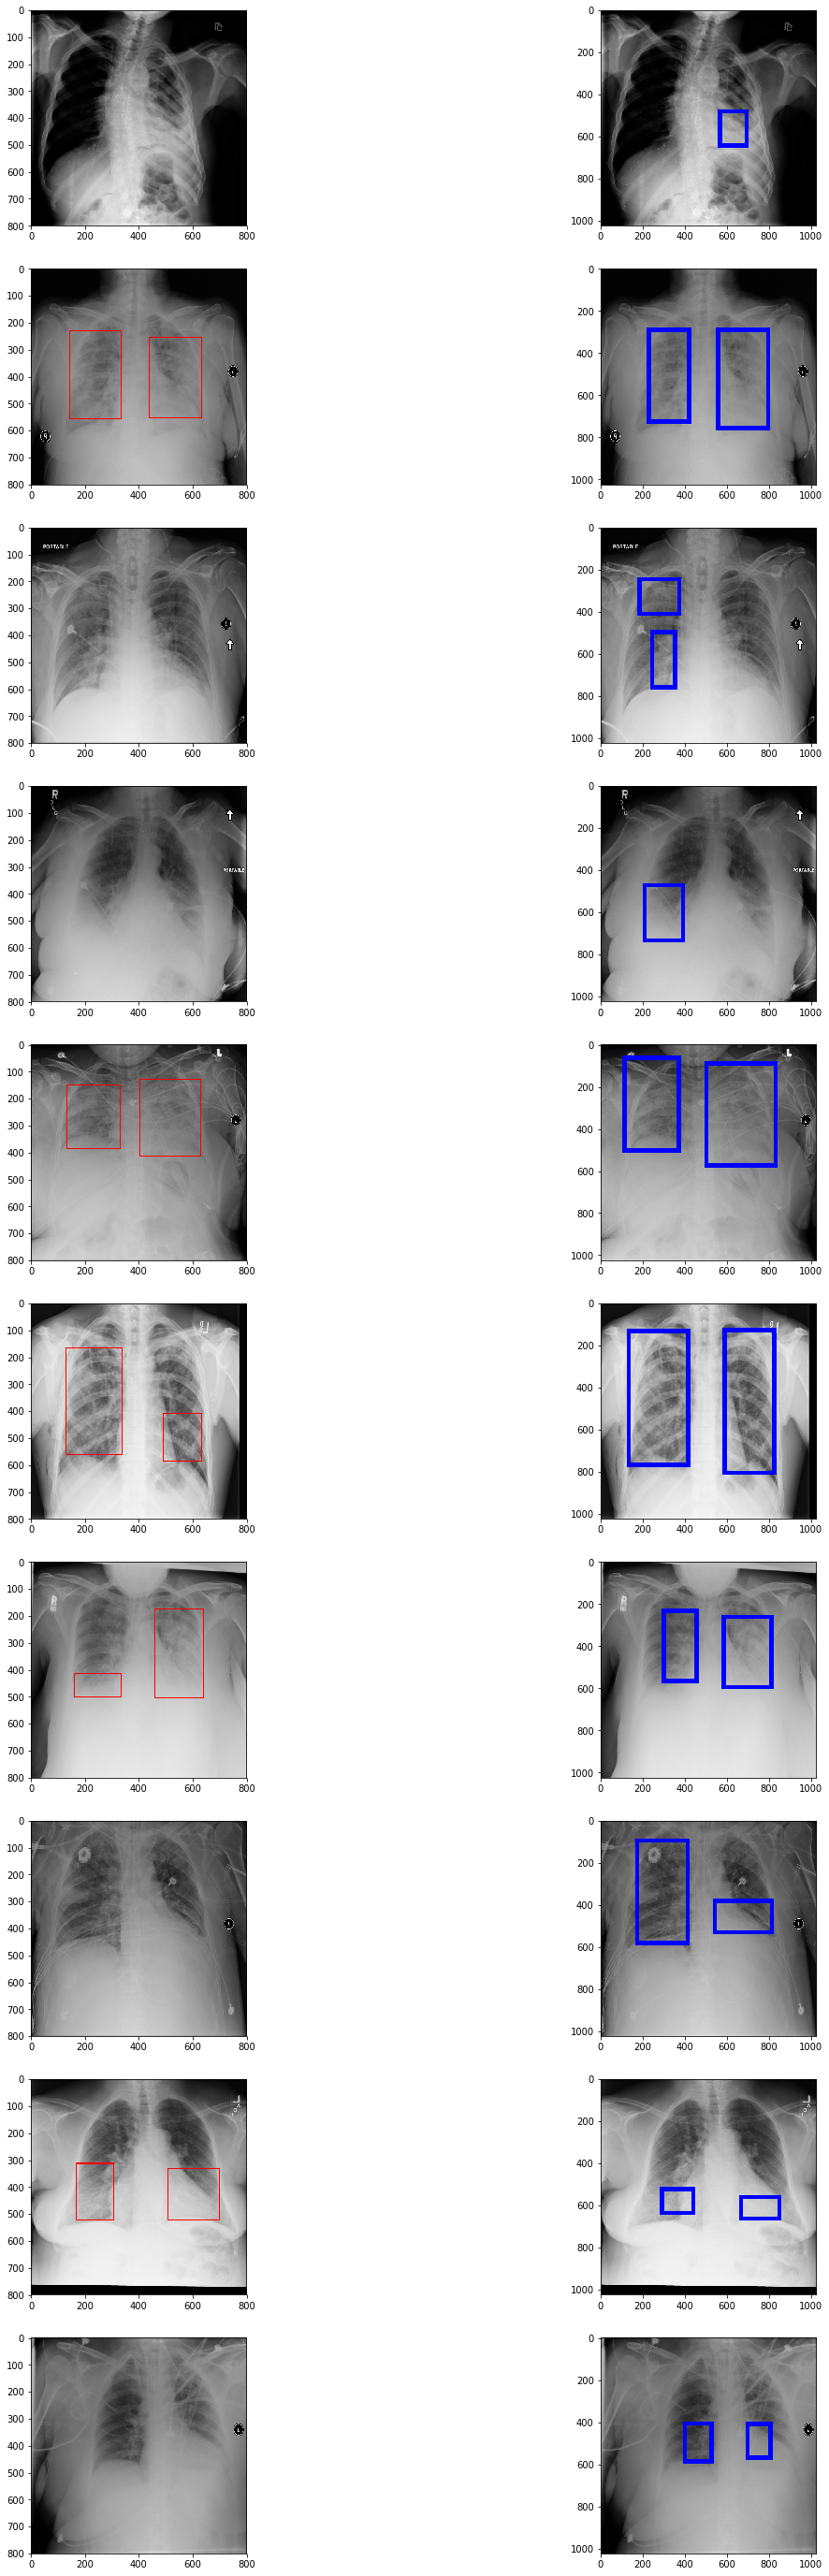

In [63]:
thickness = 20
f, axs = plt.subplots(10,2,figsize=(20,50))
for i in range(10):
    l1 = lines[i+num_train]
    l2 = l1.split()
    d = pydicom.read_file(l2[0])
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8')) 
    img = Image.fromarray(r_image,'RGB')
    plt.subplot(10,2,i*2+1)
    plt.imshow(img)

    image=Image.fromarray(image,'RGB')
    draw = ImageDraw.Draw(image)
    box = np.array([np.array(list(map(int,box.split(',')))) for box in l2[1:]])
    print(box)
    for jj in range(box.shape[0]):
        left, top, right, bottom, dummy = box[jj,:]
        print(left,top,right,bottom)
        for j in range(thickness):
            draw.rectangle(
                [left + j, top + j, right - j, bottom - j],
                outline='blue')
    del draw
    plt.subplot(10,2,i*2+2)
    plt.imshow(image)
plt.show()

In [58]:
box

array([], shape=(0, 4), dtype=float32)

In [86]:
df = pd.read_csv('input/stage_1_sample_submission.csv')
submit_file_path = "submission.csv"
submit_dict = {"patientId": [], "PredictionString": []}

for i in range(len(df)):
    patient_id = df['patientId'][i]
    d = pydicom.read_file(path.join('input','stage_1_test_images', patient_id +'.dcm'))
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8'))  
    box = box *  image.shape[0]/ ss       
    submit_line = ""
    for e in range(box.shape[0]):
        confi = score[e]
        w = box[e,3]-box[e,1]
        h = box[e,2]-box[e,0]
        x = box[e,1]
        y = box[e,0]
        submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)

    submit_dict["patientId"].append(patient_id)
    submit_dict["PredictionString"].append(submit_line)

Found 0 boxes for img
Time:  0.1819637133176002
Found 1 boxes for img
Time:  0.1675113853843868
Found 2 boxes for img
Time:  0.16211147803278436
Found 1 boxes for img
Time:  0.1614389734713768
Found 0 boxes for img
Time:  0.160117250517942
Found 0 boxes for img
Time:  0.16237073071351915
Found 2 boxes for img
Time:  0.16213942143531312
Found 0 boxes for img
Time:  0.16586582944091788
Found 0 boxes for img
Time:  0.15736668823501532
Found 1 boxes for img
Time:  0.1617333106478327
Found 0 boxes for img
Time:  0.16088724650671793
Found 1 boxes for img
Time:  0.1638154046386262
Found 0 boxes for img
Time:  0.16880454396959976
Found 0 boxes for img
Time:  0.16533117900053185
Found 0 boxes for img
Time:  0.15771877510997
Found 0 boxes for img
Time:  0.1573443335119009
Found 0 boxes for img
Time:  0.1613113652647371
Found 2 boxes for img
Time:  0.1651042164730825
Found 0 boxes for img
Time:  0.16046436967826594
Found 0 boxes for img
Time:  0.15863687113414926
Found 0 boxes for img
Time:  0.15

Found 0 boxes for img
Time:  0.1743010113023047
Found 0 boxes for img
Time:  0.16380019100870413
Found 0 boxes for img
Time:  0.16054788940346043
Found 0 boxes for img
Time:  0.15972542191502725
Found 0 boxes for img
Time:  0.16285259917185613
Found 0 boxes for img
Time:  0.16257223369575513
Found 1 boxes for img
Time:  0.16512346637318842
Found 1 boxes for img
Time:  0.15960153949527012
Found 0 boxes for img
Time:  0.163489398272759
Found 0 boxes for img
Time:  0.16253808064811892
Found 1 boxes for img
Time:  0.16360117188469303
Found 1 boxes for img
Time:  0.15879832190512388
Found 2 boxes for img
Time:  0.16297803400175326
Found 0 boxes for img
Time:  0.16362632094660512
Found 0 boxes for img
Time:  0.16538830773515656
Found 0 boxes for img
Time:  0.16666842606537102
Found 1 boxes for img
Time:  0.16552895619588526
Found 1 boxes for img
Time:  0.16352075698068802
Found 0 boxes for img
Time:  0.16264737040182808
Found 0 boxes for img
Time:  0.15896442991106596
Found 0 boxes for img
T

Found 0 boxes for img
Time:  0.1605056638172755
Found 2 boxes for img
Time:  0.15958787827548804
Found 0 boxes for img
Time:  0.1586104801417605
Found 0 boxes for img
Time:  0.16662806337262737
Found 0 boxes for img
Time:  0.15929416206472524
Found 0 boxes for img
Time:  0.16173827836428245
Found 0 boxes for img
Time:  0.16846456590155867
Found 0 boxes for img
Time:  0.16380733210098697
Found 2 boxes for img
Time:  0.1733869515483093
Found 0 boxes for img
Time:  0.1650666481209555
Found 0 boxes for img
Time:  0.16382006187359366
Found 0 boxes for img
Time:  0.1638054692066362
Found 0 boxes for img
Time:  0.16837048977959057
Found 1 boxes for img
Time:  0.16452206224766996
Found 0 boxes for img
Time:  0.1633937697388319
Found 1 boxes for img
Time:  0.1651135309411984
Found 1 boxes for img
Time:  0.1658046644370188
Found 0 boxes for img
Time:  0.16353659157539369
Found 0 boxes for img
Time:  0.16537526748015807
Found 1 boxes for img
Time:  0.1640504397046243
Found 1 boxes for img
Time:  

Found 0 boxes for img
Time:  0.16382347717808443
Found 0 boxes for img
Time:  0.15637873370451416
Found 0 boxes for img
Time:  0.16080621063792933
Found 0 boxes for img
Time:  0.16173082678960782
Found 1 boxes for img
Time:  0.17029392734002613
Found 0 boxes for img
Time:  0.17211770009635075
Found 0 boxes for img
Time:  0.15738811151004484
Found 0 boxes for img
Time:  0.15716704814531113
Found 0 boxes for img
Time:  0.15966643028605176
Found 1 boxes for img
Time:  0.16070064667292172
Found 0 boxes for img
Time:  0.16351920456963853
Found 0 boxes for img
Time:  0.16012408112783305
Found 0 boxes for img
Time:  0.15959626129642857
Found 1 boxes for img
Time:  0.16001075510575902
Found 0 boxes for img
Time:  0.1625517418669915
Found 0 boxes for img
Time:  0.16156006154960778
Found 0 boxes for img
Time:  0.16155478335167572
Found 2 boxes for img
Time:  0.16382999730467418
Found 0 boxes for img
Time:  0.1641563141538427
Found 0 boxes for img
Time:  0.1755156178778634
Found 0 boxes for img
T

Found 0 boxes for img
Time:  0.1594872820260207
Found 0 boxes for img
Time:  0.16104869727860205
Found 0 boxes for img
Time:  0.16756696170705254
Found 2 boxes for img
Time:  0.16705187164916424
Found 0 boxes for img
Time:  0.17320749280588643
Found 1 boxes for img
Time:  0.16202205914305523
Found 0 boxes for img
Time:  0.1611725796974497
Found 1 boxes for img
Time:  0.1623188801768265
Found 0 boxes for img
Time:  0.16536657397773524
Found 2 boxes for img
Time:  0.16678578835762892
Found 0 boxes for img
Time:  0.16740085370201996
Found 1 boxes for img
Time:  0.1681692972788369
Found 0 boxes for img
Time:  0.1610080241034666
Found 0 boxes for img
Time:  0.1618733381437778
Found 0 boxes for img
Time:  0.16232726319867652
Found 2 boxes for img
Time:  0.16813731760703376
Found 1 boxes for img
Time:  0.16720680229354912
Found 0 boxes for img
Time:  0.16715960899091442
Found 0 boxes for img
Time:  0.16109123334717879
Found 1 boxes for img
Time:  0.16493003592859168
Found 1 boxes for img
Time

Found 0 boxes for img
Time:  0.1651157043170315
Found 0 boxes for img
Time:  0.16658180151716806
Found 2 boxes for img
Time:  0.1751185110761071
Found 0 boxes for img
Time:  0.16254335884696047
Found 0 boxes for img
Time:  0.16773244874821103
Found 0 boxes for img
Time:  0.1740644238252571
Found 0 boxes for img
Time:  0.16483658077049768
Found 0 boxes for img
Time:  0.17526164339506067
Found 0 boxes for img
Time:  0.16575840258065
Found 0 boxes for img
Time:  0.16236886782007787
Found 0 boxes for img
Time:  0.1661337756258945
Found 1 boxes for img
Time:  0.16756851411901152
Found 0 boxes for img
Time:  0.1679817659978653
Found 1 boxes for img
Time:  0.16338072948474291
Found 0 boxes for img
Time:  0.16308049314557138
Found 1 boxes for img
Time:  0.16988191738983005
Found 0 boxes for img
Time:  0.17373407070772373
Found 0 boxes for img
Time:  0.15964842231551302
Found 0 boxes for img
Time:  0.16242133932155411
Found 0 boxes for img
Time:  0.1743224345782437
Found 0 boxes for img
Time:  

In [91]:
sdf = pd.DataFrame(submit_dict)
sdf = sdf[['patientId','PredictionString']]
sdf.to_csv(submit_file_path, index=False)

In [84]:
f, axs = plt.subplots(10,1,figsize=(10,50))
for i in range(10):
    patient_id = df['patientId'][i]
    d = pydicom.read_file(path.join('input','stage_1_test_images', patient_id +'.dcm'))
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8'))     
    submit_line = ""
    for e in range(box.shape[0]):
        confi = score[e]
        w = box[e,3]-box[e,1]
        h = box[e,2]-box[e,0]
        x = box[e,1]
        y = box[e,0]
        submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)
    img = Image.fromarray(r_image,'RGB')
    plt.subplot(10,1,i+1)
    plt.imshow(img)
    #submit_dict["patientId"].append(patient_id)
    #submit_dict["PredictionString"].append(submit_line)
plt.show() 

Found 0 boxes for img
Time:  0.1699362517838381
Found 1 boxes for img
Time:  0.16660912395582272
Found 2 boxes for img
Time:  0.17069413896388141
Found 1 boxes for img
Time:  0.15816649051976128
Found 0 boxes for img
Time:  0.17595060351595748
Found 0 boxes for img
Time:  0.17342514086521987
Found 2 boxes for img
Time:  0.1587831082752018
Found 0 boxes for img
Time:  0.17613813479692908
Found 0 boxes for img
Time:  0.16457111844374595
Found 1 boxes for img
Time:  0.1623170172842947


<function matplotlib.pyplot.show>

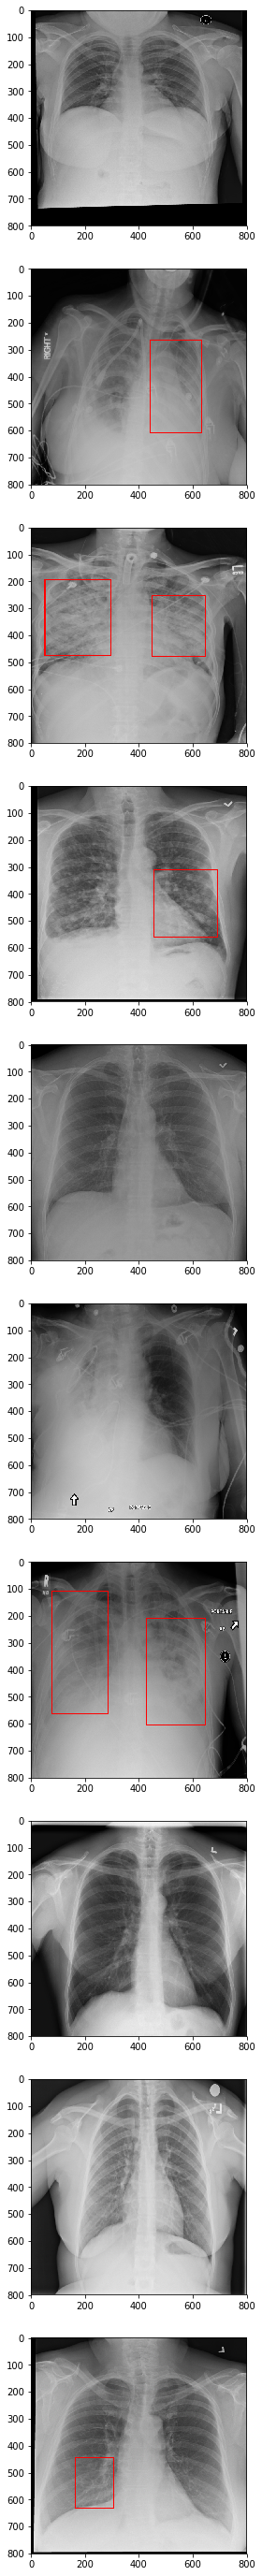

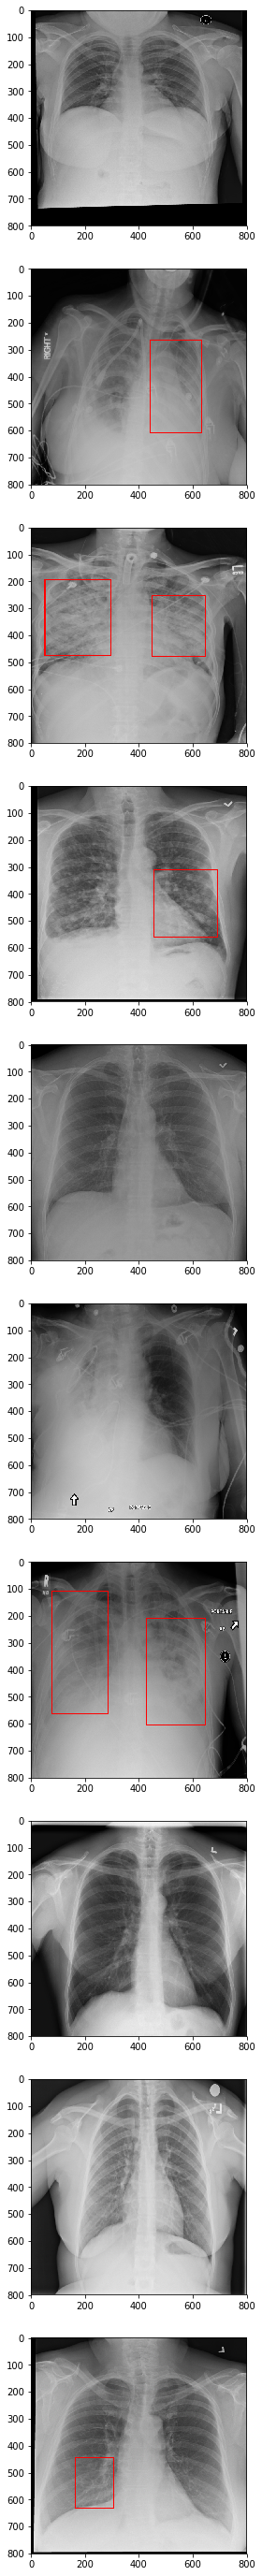

In [85]:
plt.show()

In [ ]:
# from keras import backend as K
# from yolo3.model import yolo_eval
# sess = K.get_session()
# image_data = im/255.
# image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
# print(image_data.shape)

# boxes, scores, classes = yolo_eval(model.output, anchors,
#         1,input_shape,4,
#         score_threshold= 0.3, iou_threshold=0.45)


# out_boxes, out_scores, out_classes = sess.run(
#     [boxes, scores, classes],
#     feed_dict={
#         model.input: image_data,
#         input_image_shape: [ss, ss],
#         K.learning_phase(): 0
#     })

In [88]:
image.shape[0]/ss

1.28

In [89]:
ss

800

In [11]:
model.load_weights(log_dir + 'trained_weights_stage_1.h5')

In [12]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.

for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
print('Unfreeze all of the layers.')

batch_size = 1 # note that more GPU memory is required after unfreezing the body
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=80,
    initial_epoch=50,
    callbacks=[logging, checkpoint, reduce_lr, early_stopping])
model.save_weights(log_dir + 'trained_weights_final.h5')

# Further training if needed.

Unfreeze all of the layers.
Train on 5094 samples, val on 565 samples, with batch size 1.
Epoch 51/80
5094/5094 [==============================] - 3048s 598ms/step - loss: 22.3318 - val_loss: 20.9374
Epoch 52/80
5094/5094 [==============================] - 3031s 595ms/step - loss: 20.1177 - val_loss: 20.2306
Epoch 53/80
5094/5094 [==============================] - 3029s 595ms/step - loss: 18.4337 - val_loss: 17.8845
Epoch 54/80
5094/5094 [==============================] - 3029s 595ms/step - loss: 16.4936 - val_loss: 16.5959
Epoch 55/80
5094/5094 [==============================] - 3029s 595ms/step - loss: 15.3368 - val_loss: 15.7784
Epoch 56/80
5094/5094 [==============================] - 3030s 595ms/step - loss: 14.2983 - val_loss: 15.8266
Epoch 57/80
5094/5094 [==============================] - 3027s 594ms/step - loss: 13.8518 - val_loss: 16.4383
Epoch 58/80
5094/5094 [==============================] - 3028s 594ms/step - loss: 12.3881 - val_loss: 16.9956

Epoch 00058: ReduceLROnPlatea